# Essaie de modèle de clustering pour regrouper les musiques en fonction de leurs charactéristiques musicales

Entraine le modèle sur toutes les pistes disponibles, puis applique le modèle aux pistes qui ont des hashtags pour évaluer le modèle avec un wordclouds.
Le modèle est aussi appliqué à un dataset indépendant où les noms et les groupes des morceaux sont disponibles, ce qui permet de tester la cohérence des groupes d'une autres façon.

# Table of content: <a class="anchor" id="TOC"></a>
* [Import packages + data](#package_data)
** [Filter data](#filter_data)
** [Process data](#process_data)
* [K-means model](#model-Kmean)
** [Check number of classes](#prepare_classKmean)
** [Apply model](#prepare_modelKmean)
** [Evaluate model](#evaluate_modelKmean)
* [Test with a second dataset](#second-dataset)

# Packages and data <a class="anchor" id="package_data"></a>
[back to table of content](#TOC)

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [2]:
## read global file built from projDS-00-fichiers

# data - simplify to keep only some useful data
data = pd.read_csv('df_global.csv', index_col='index') 
data = data[['track_id','hashtag','instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']]
display(data.head());


## Database to use only the most common genres of music:
#genres = pd.read_csv('genres.csv')
#genres = pd.read_csv('genres-nico.csv', names=['title'], header=None, sep=',') #updated from Nico
genres = pd.read_csv('genres-nico-simplified.csv', names=['title'], header=None, sep=',') #updated from Nico to simplify
genres = genres['title'].str.lower()
genres ## 163 "hashtags" or 28 from Nico


,track_id,hashtag,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
index,,,,,,,,,,,
0,cd52b3e5b51da29e5893dba82a418a4b,goth,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697
1,cd52b3e5b51da29e5893dba82a418a4b,deathrock,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697
2,cd52b3e5b51da29e5893dba82a418a4b,postpunk,0.00479,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697
3,da3110a77b724072b08f231c9d6f7534,80s,0.01770,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826
4,da3110a77b724072b08f231c9d6f7534,retro,0.01770,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826


0        acoustic
1     alternative
2           blues
3         classic
4         country
5           dance
6           disco
7      electronic
8            funk
9          gospel
10           goth
11         hiphop
12          house
13          indie
14           jazz
15          latin
16         lounge
17          metal
18            pop
19          psych
20           punk
21            rap
22         reggae
23            rnb
24           rock
25           soul
26         techno
27        triphop
Name: title, dtype: object

In [3]:
## count how many tracks have each genre:
#data_genre[data_genre.hashtag == "classic"]['track_id'].count()

data_genre = data[['track_id','hashtag']].drop_duplicates(keep='first')
genres_test = pd.DataFrame(genres)
list_cnt=[]
for i in genres:   
    cnt=data_genre[data_genre.hashtag == i]['track_id'].count()
    list_cnt.append(cnt)

#genres[genres.str.contains('hiphop') == True]
genres_test['Count']=list_cnt
genres_test.head()


,title,Count
0,acoustic,128
1,alternative,248
2,blues,1556
3,classic,698
4,country,485


In [4]:
hasht="pop"
print('Absolute:',data_genre[data_genre.hashtag == hasht]['track_id'].count())
print('Inclusive:',data_genre.loc[data_genre.hashtag.apply(lambda x: True if hasht in x else False)]['track_id'].count())

Absolute: 156
Inclusive: 1382


In [5]:
## display how many tracks have exact keyword
pd.set_option('display.max_rows', genres_test.shape[0]+1)
print(genres_test.sort_values(by='Count', ascending=False))

          title  Count
24         rock   3128
17        metal   3067
8          funk   2695
14         jazz   2083
10         goth   2010
11       hiphop   1772
12        house   1732
2         blues   1556
6         disco   1299
25         soul   1198
13        indie   1031
23          rnb    904
3       classic    698
20         punk    690
7    electronic    584
22       reggae    564
4       country    485
5         dance    399
21          rap    359
19        psych    251
1   alternative    248
9        gospel    215
26       techno    192
18          pop    156
0      acoustic    128
16       lounge    117
15        latin    117
27      triphop    109


## Filter data <a class="anchor" id="filter_data"></a>

#### DATA FOR MODEL : keeps all songs

In [6]:
#### Keep all data for model training:

data_clean = data[['track_id','instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']]

## Keep 1 entry per song:
data_clean = data_clean.drop_duplicates(keep='first');
display(data_clean.head());

## drop track id as not useful anymore:
list_trackid = data_clean['track_id'] ; #save track id in a list
data_clean = data_clean.drop('track_id', axis=1);

## Check some info:
display(data.info(show_counts=True)) # 6356931 rows
display(data_clean.info(show_counts=True)) # 161456 rows i.e. unique tracks

data_used = data_clean # set this as a data to use

,track_id,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
index,,,,,,,,,,
0,cd52b3e5b51da29e5893dba82a418a4b,0.004790,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697
3,da3110a77b724072b08f231c9d6f7534,0.017700,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826
6,33f95122281f76e7134f9cbea3be980f,0.000000,0.1430,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574
7,b5c42e81e15cd54b9b0ee34711dedf05,0.000183,0.3620,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739
8,8bd5206b84c968eda0af8bc86d6ab1d1,0.000000,0.1100,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6356931 entries, 0 to 6356935
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   track_id          6356931 non-null  object 
 1   hashtag           6356931 non-null  object 
 2   instrumentalness  6356931 non-null  float64
 3   liveness          6356931 non-null  float64
 4   speechiness       6356931 non-null  float64
 5   danceability      6356931 non-null  float64
 6   valence           6356931 non-null  float64
 7   loudness          6356931 non-null  float64
 8   tempo             6356931 non-null  float64
 9   acousticness      6356931 non-null  float64
 10  energy            6356931 non-null  float64
dtypes: float64(9), object(2)
memory usage: 582.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161456 entries, 0 to 6356920
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   instrumentalness  161456 non-null  float64
 1   liveness          161456 non-null  float64
 2   speechiness       161456 non-null  float64
 3   danceability      161456 non-null  float64
 4   valence           161456 non-null  float64
 5   loudness          161456 non-null  float64
 6   tempo             161456 non-null  float64
 7   acousticness      161456 non-null  float64
 8   energy            161456 non-null  float64
dtypes: float64(9)
memory usage: 12.3 MB


None

#### DATA FOR EVALUATION : keeps only songs corresponding to common hashtags

In [7]:
#### Keep only useful data:

## selecting hastags from genres file - 100 sampling per hastag:
data_filter_evaluate = data.drop_duplicates(keep='first');
data_filter_evaluate = data_filter_evaluate.loc[data_filter_evaluate.hashtag.apply(lambda x: True if any(i == x for i in genres) else False)] #use "in" instead of "==" for larger selection
##data_filter = data_filter[(data_filter['hashtag'].str.contains('radio') == False)]
data_filter_evaluate = data_filter_evaluate.groupby("hashtag").sample(n=100) #keep only 100 entries per genre


# save data without hashtags
data_clean_evaluate = data_filter_evaluate[['track_id','instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']]

## Keep 1 entry per song:
#data_clean = data_clean.drop_duplicates(keep='first'); # pas utile ici? 
display(data_clean.head());

## drop track id as not useful anymore:
list_trackid_evaluate = data_clean_evaluate['track_id'] ; #save track id in a list
data_clean_evaluate = data_clean_evaluate.drop('track_id', axis=1);

list_trackid_raw = data['track_id'].drop_duplicates(keep='first');

## Check some info:
display("Tracks after cleaning:",data_clean_evaluate.info(show_counts=True)) # 32401/34246 rows i.e. unique tracks

data_evaluate = data_clean_evaluate # set this as a data to use

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
index,,,,,,,,,
0,0.004790,0.1800,0.0294,0.634,0.342,-8.345,125.044,0.00035,0.697
3,0.017700,0.0638,0.0624,0.769,0.752,-8.252,95.862,0.26700,0.826
6,0.000000,0.1430,0.0292,0.324,0.333,-5.647,74.101,0.23900,0.574
7,0.000183,0.3620,0.0524,0.767,0.808,-5.011,114.237,0.03640,0.739
8,0.000000,0.1100,0.0375,0.641,0.912,-4.271,93.010,0.02680,0.787


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 4930723 to 5215898
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instrumentalness  2800 non-null   float64
 1   liveness          2800 non-null   float64
 2   speechiness       2800 non-null   float64
 3   danceability      2800 non-null   float64
 4   valence           2800 non-null   float64
 5   loudness          2800 non-null   float64
 6   tempo             2800 non-null   float64
 7   acousticness      2800 non-null   float64
 8   energy            2800 non-null   float64
dtypes: float64(9)
memory usage: 218.8 KB


'Tracks after cleaning:'

None

## Process chosen data <a class="anchor" id="process_data"></a>

In [8]:
## Scale all features:
# (except track id)

scaler = StandardScaler();
scaler.fit(data_used);
data_used[['instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']] = scaler.transform(data_used[['instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']]);


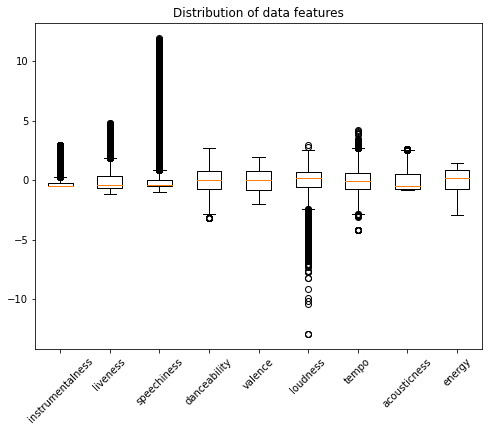

In [9]:
lst=[data_used['instrumentalness'],data_used['liveness'],data_used['speechiness'],data_used['danceability'],data_used['valence'],data_used['loudness'],data_used['tempo'],data_used['acousticness'],data_used['energy']];

fig = plt.figure(figsize=(8,6))
plt.boxplot(lst, showfliers=True);
plt.title('Distribution of data features');
plt.xticks([1,2,3,4,5,6,7,8,9],['instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy'], rotation=45);

# K-means model <a class="anchor" id="model-Kmean"></a>
[back to table of content](#TOC)

##  Check number of classes <a class="anchor" id="prepare_classKmean"></a>

In [10]:
## Method K-means

# Need to find an optimal number of classes:
# Check manually with distances
from scipy.spatial.distance import cdist 
from sklearn.metrics import silhouette_score

# k to test:
lst = np.linspace(2,50,49);

# to record different metrics:
distortions = [];
sse = [];
silhouette_coeff = [];

for n in lst:
    kmeans=KMeans(n_clusters=np.int(n))
    kmeans.fit(data_used)
    #score 1
    distance=sum(np.min(cdist(data_used, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.size(data_used, axis = 0)
    distortions.append(distance)
    #score 2
    sse.append(kmeans.inertia_)
    #score 3 TOO SLOW !!!!! and not very useful in the end...
    #score = silhouette_score(data_clean, kmeans.labels_)
    #silhouette_coeff.append(score)



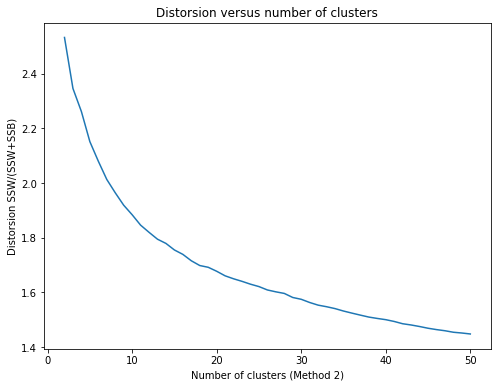

In [11]:
##Plot results 

fig = plt.figure(figsize=(8,6))
plt.plot(lst,distortions);
plt.xlabel('Number of clusters (Method 2)');
plt.ylabel('Distorsion SSW/(SSW+SSB)');
plt.title('Distorsion versus number of clusters');

## k=5-10 seems to be a good number


Save results to avoid computing again:
distortions = [2.533125270423945, 2.346396395622829, 2.2618501145882646, 2.1518137632791934, 2.0802222401272963, 2.01342786881318, 1.9651371709785364, 1.9190812260472176, 1.8841749073479301, 1.8460828121655386, 1.8196930576572543, 1.7945946759633966, 1.7699691560002113, 1.7551452393220786, 1.7350315775332357, 1.715666458077897, 1.7021796806727865, 1.6851130722441812, 1.6776456909228579, 1.660402909731525, 1.650990946317789, 1.6379497258416413, 1.6283965524993027, 1.6198738174818712, 1.6060532624344173, 1.5999493395615334, 1.588223542357226, 1.5813409790034376, 1.5740262501399893, 1.5663166233066752, 1.5568351482740834, 1.5455509585160645, 1.5407547523520109, 1.5335134210829424, 1.5267891219903333, 1.5200689487878387, 1.5103322748349108, 1.5043344662798195, 1.499204614634435, 1.495057201040958, 1.4847812560791096, 1.4839868219847092, 1.4773570522515074, 1.4679135566905366, 1.4656189365066035, 1.4589911366303312, 1.454275894232613, 1.448151356286108, 1.4462582073289576]

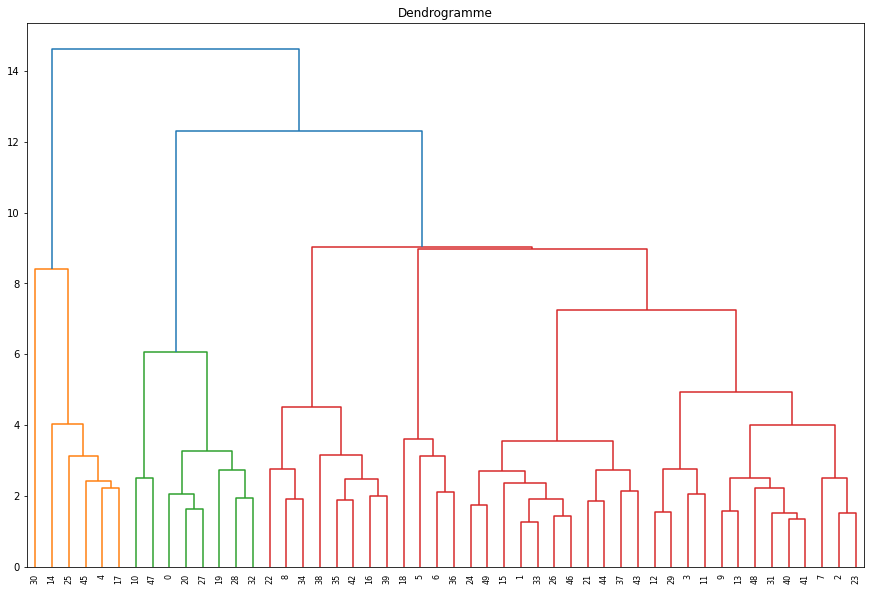

In [12]:
## Analyse with dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

kmeans = KMeans(n_clusters = 50)
kmeans.fit(data_used)
# Centroids and labels
labels_kmeans = kmeans.labels_
centroids_kmeans = kmeans.cluster_centers_

# plot
plt.figure(figsize=(15, 10))
Z = linkage(centroids_kmeans, method = 'ward', metric = 'euclidean');
dendrogram(Z,  leaf_rotation = 90.);
#dend = dendrogram(linkage(data_used, method='ward'), p=50)
plt.title("Dendrogramme");
plt.show();

## 6 classes would have enough distance (level 8) 

## Apply K-means model <a class="anchor" id="prepare_modelKmean"></a>

In [13]:
## Apply k-means model

#number of classes chosen
n_class= 6

# model
kmeans=KMeans(n_clusters=n_class, random_state=1234)
kmeans.fit(data_used)

# Centroids and labels
labels_kmeans = kmeans.labels_
centroids_kmeans = kmeans.cluster_centers_

# Define some colors to plot labels later:
#colors = np.random.rand(n_class)
#c = plt.cm.gist_rainbow(colors)
c = ['grey',"darkblue","green","cyan","orange","red","purple"]

## Evaluate model <a class="anchor" id="evaluate_modelKmean"></a>

In [14]:
## combine results with track id

data_evaluate_features = scaler.transform(data_evaluate);
labels_kmeans_evaluate = kmeans.predict(data_evaluate_features);

list_trackid_evaluate = pd.DataFrame(list_trackid_evaluate)
list_trackid_evaluate['labels'] = labels_kmeans_evaluate
list_trackid_evaluate.head()

# merge with data to add "labels" on each track entry
# keep only useful column to describe tracks
data_merge = pd.merge(data_filter_evaluate, list_trackid_evaluate, on='track_id')[['track_id','hashtag','labels']];
data_merge.drop_duplicates(inplace=True); #make sure only 1 same hashtag for a song

display(data_merge.info())
data_merge.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 3207
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  2800 non-null   object
 1   hashtag   2800 non-null   object
 2   labels    2800 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 76.6+ KB


None

,track_id,hashtag,labels
0,e186b00af6413ee2c026fe077be992c9,acoustic,5
1,6acb44d01e7df03f3459c71c5fe8dd93,acoustic,5
2,3c58ce49b515943426d4bdd47dd098d7,acoustic,5
3,ca54a1a83a9cccd97b79e97099993a6c,acoustic,5
4,43376064db7e462fc255d1f64de24eeb,acoustic,5


In [339]:
# propose nb recommandations à partir d'un morceau
def track_recommandations(track_id, nb):
    label = data_merge[data_merge['track_id']==track_id]['labels'].unique().item()
    return data_merge[data_merge['labels']==label][:nb]

In [229]:
track_recommandations('e186b00af6413ee2c026fe077be992c9',5)


,track_id,hashtag,labels
0,e186b00af6413ee2c026fe077be992c9,acoustic,5
1,6acb44d01e7df03f3459c71c5fe8dd93,acoustic,5
2,3c58ce49b515943426d4bdd47dd098d7,acoustic,5
3,ca54a1a83a9cccd97b79e97099993a6c,acoustic,5
4,43376064db7e462fc255d1f64de24eeb,acoustic,5


In [260]:
track_recommandations('4b3ef7a10fcde82f244713af5d61fe92',5)


,track_id,hashtag,labels
12,85e11afa71ec0520a64d016839563323,acoustic,1
13,34ced0fc1065ca7ecbf35a02b55c131c,acoustic,1
14,63165fc7afb90f6e2b3113f867b63940,acoustic,1
24,e9749c7231c407018a7bd1d28f8d77e9,acoustic,1
27,34bfaa8b7d65690a785db674a447c300,acoustic,1


In [207]:
labels=['jazz-acoustic','disco-funk','rap-rnb','gospel-blues','techno-psych','metal-country']

data_merge['hashtag'].unique()


array(['acoustic', 'indie', 'pop', 'alternative', 'techno', 'latin',
       'house', 'punk', 'electronic', 'rock', 'dance', 'classic',
       'gospel', 'blues', 'psych', 'reggae', 'jazz', 'hiphop', 'disco',
       'country', 'lounge', 'rap', 'funk', 'soul', 'triphop', 'rnb',
       'goth', 'metal'], dtype=object)

In [629]:
# random
random_tune = data_merge.iloc[np.random.randint(0,len(data_merge.index)+1)].track_id

print('morceau de référence :', random_tune)
print('hashtag :', data_merge[data_merge['track_id']==random_tune]['hashtag'].tolist())
trk_label = data_merge[data_merge['track_id']==random_tune]['labels']
if len(trk_label)>1:
    print('label : [', trk_label.unique(),':',labels[trk_label.unique().item()],']')
else:
    print('label : [', trk_label.item(),':',labels[trk_label.item()],']')

track_recommandations(random_tune,5)


morceau de référence : d967db99cb358341ec06287b14c485c6
hashtag : ['metal']
label : [ 4 : techno-psych ]


,track_id,hashtag,labels
49,3bb38331d88e6b6dfe627e15db190075,acoustic,4
57,d5fc0e7dd33205244c97bbf13a7fa822,acoustic,4
95,a5452c50af87568b010061c1f0e49d3a,acoustic,4
130,47ba1f3acab95e3cf8d30843abb5032c,alternative,4
138,e1ddf8e992f653333094683896072f95,alternative,4


In [295]:
# incoherences
data_merge[(data_merge['hashtag']=='acoustic') & (data_merge['labels']!=0) & (data_merge['labels']!=5)].tail()

,track_id,hashtag,labels
110,18939d2d70af5b04dc6f09efdd1f4856,acoustic,1
111,57fc0d783fd0f733b884b061b93168cb,acoustic,1
115,55921396223b861bde89968a777532c0,acoustic,1
119,7015d076cdaec15204dbbec73a91b95d,acoustic,1
121,0f6c3e42bc32d33710b9e066a14d6374,acoustic,1


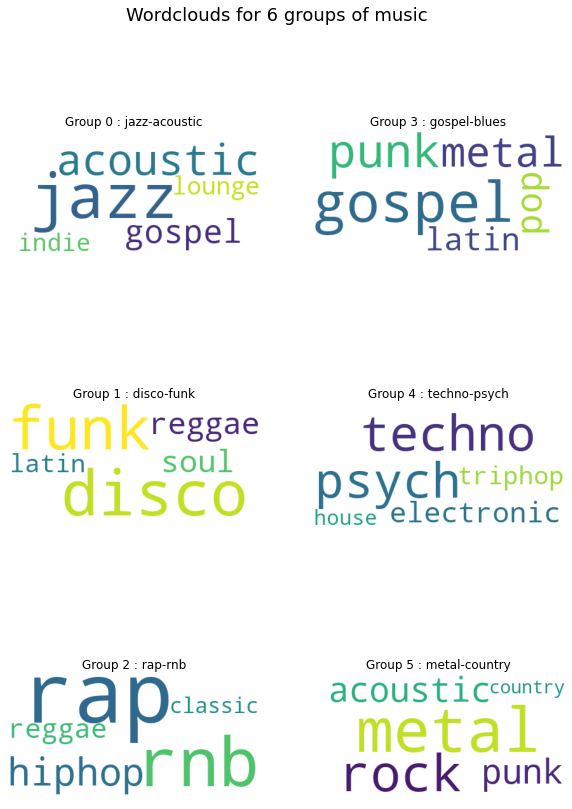

In [33]:
### Display WordClouds
# cf : https://datascientest.com/wordcloud-python
#wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
from wordcloud import WordCloud

xclass=int(0.5+n_class/2)
yclass=int(0.5+n_class/2)-int(n_class/2) #0 if even, 1 if uneven
labels=['jazz-acoustic','disco-funk','rap-rnb','gospel-blues','techno-psych','metal-country']

#plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(xclass, 2, figsize=(10, 15))

i=0;j=0;
for n in range(0,n_class):
    idx=j*xclass+i
    lab=labels[idx]
    df_test = data_merge[data_merge['labels']==idx][['hashtag','labels']]
    wordcloud = WordCloud(background_color = 'white', max_words = 5, collocations=False).generate(' '.join(df_test['hashtag']))
    axs[i, j].imshow(wordcloud)
    axs[i, j].axis("off")
    axs[i, j].set_title('Group {} : {}'.format(n, lab))
    i+=1;
    if (n==xclass-1):
        j+=1;
        i=0;
        
# if needed, delete axis of last sub-plot        
if yclass==1:
    axs[i, j].axis("off")  

plt.gcf().text(0.5, 0.92, 'Wordclouds for {} groups of music'.format(n_class), fontsize=18, horizontalalignment='center', verticalalignment='center') ;

plt.subplots_adjust(hspace=0.4)

plt.show();



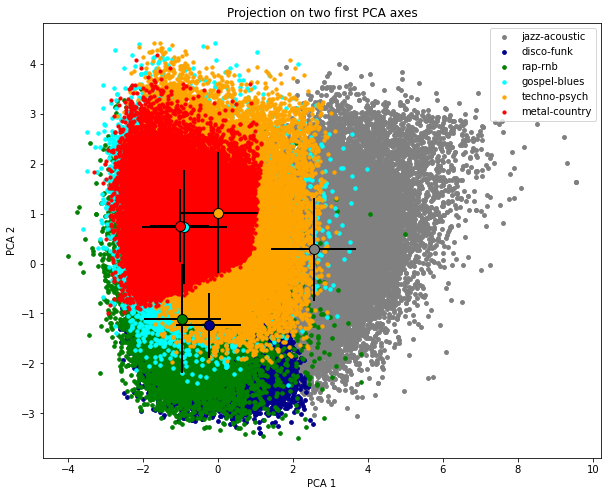

In [16]:
#Analyse avec PCA sur le modèle K-Means:

pca = PCA(n_components=2);
data_2D = pca.fit_transform(X=data_used);

fig = plt.figure(figsize=(10,8))
#plt.scatter(data_2D[:,0],data_2D[:,1],c=labels_clf, cmap=plt.cm.Spectral)
for label in np.unique(labels_kmeans):
    lab=labels[label]
    plt.scatter(data_2D[labels_kmeans==label, 0], data_2D[labels_kmeans==label, 1], facecolors=c[label], s=15-label, label=lab)
# add mean of each group and std
for label in np.unique(labels_kmeans):
    avg1=data_2D[labels_kmeans==label, 0].mean()
    avg2=data_2D[labels_kmeans==label, 1].mean()
    std1=data_2D[labels_kmeans==label, 0].std()
    std2=data_2D[labels_kmeans==label, 1].std()
    plt.vlines(x=avg1, ymin=avg2-std2, ymax=avg2+std2, colors='black', linestyles='-', lw=2, zorder=9)
    plt.hlines(y=avg2, xmin=avg1-std1, xmax=avg1+std1, colors='black', linestyles='-', lw=2, zorder=9)
    plt.scatter(avg1, avg2, s=100, edgecolors="black", facecolors=c[label], zorder=10)
    
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');
plt.title("Projection on two first PCA axes");
plt.legend()

## Certains groupes sont assez clairement définis même sur un plan 2D, donc le classement n'est pas aléatoire.
# D'autres groupes sont un peu plus mélangés au reste (les 1 et 2 par exemple),mais cela peut vouloir dire que 2 dimensions ne sont pas assez pour les séparer clairement. 


Problème avec ce classement : les groupes sont difficile à différencier sur leur champ lexical. On retrouve un peu les même hashtags dans plusieurs groupes, et il manque des catégories genre "classic". 

Il faudrait peut-être équilibrer d'abord le jeu de données pour sélectionner un certain nombres de musiques par catégorie, pour éviter qu'une caté


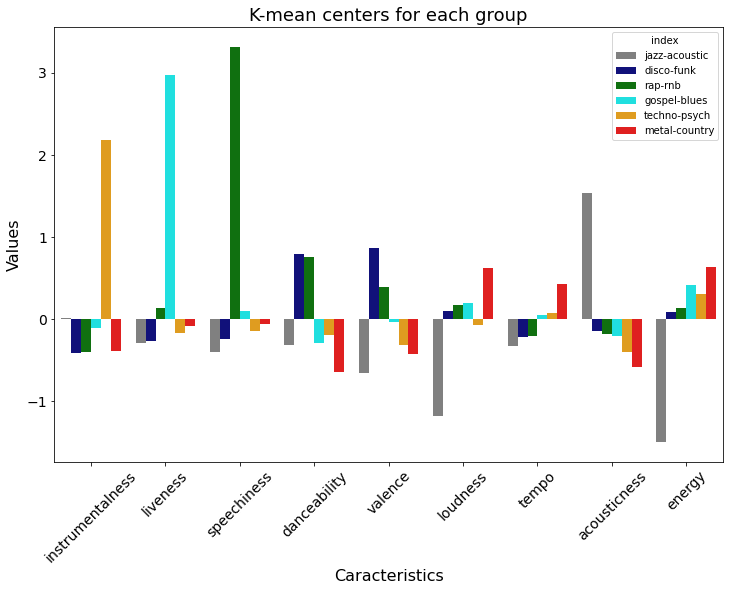

In [17]:
## Plot distribution of each caracteristics in different groups:

#labels_kmeans = kmeans.labels_
#centroids_kmeans = kmeans.cluster_centers_
fig = plt.figure(figsize=(12,8))
data_center = pd.DataFrame(centroids_kmeans, index=labels, columns=['instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']);
data_center.head(6);
data_center = data_center.reset_index().melt(id_vars=["index"]);
sns.barplot(x="variable", y="value", hue="index", palette=c, data=data_center);
plt.xticks(fontsize=14, rotation=45);
plt.yticks(fontsize=14);
plt.xlabel("Caracteristics", fontsize=16);
plt.ylabel("Values", fontsize=16);
plt.title("K-mean centers for each group", fontsize=18);


In [18]:
## Test avec t-SNE
from sklearn.manifold import  TSNE

model_tsne = TSNE(n_components = 2, random_state=1234);
data_tsne = model_tsne.fit_transform(X=data_used);




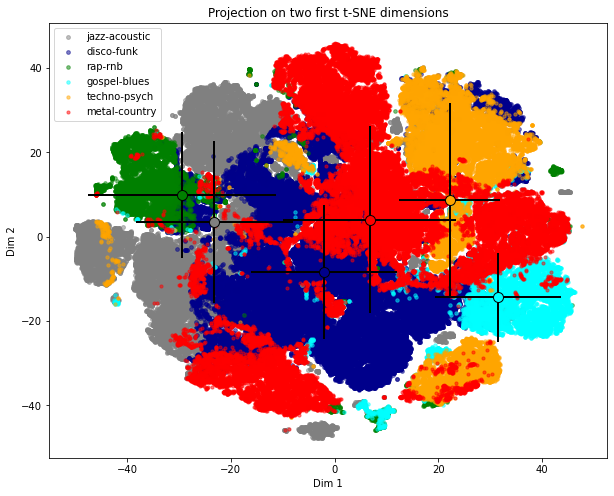

In [19]:
fig = plt.figure(figsize=(10,8))
#plt.scatter(data_2D[:,0],data_2D[:,1],c=labels_clf, cmap=plt.cm.Spectral)
for label in np.unique(labels_kmeans):
    lab=labels[label]
    plt.scatter(data_tsne[labels_kmeans==label, 0], data_tsne[labels_kmeans==label, 1], facecolors=c[label], s=15-label, label=lab, alpha=0.5)
# add mean of each group and std
for label in np.unique(labels_kmeans):
    avg1=data_tsne[labels_kmeans==label, 0].mean()
    avg2=data_tsne[labels_kmeans==label, 1].mean()
    std1=data_tsne[labels_kmeans==label, 0].std()
    std2=data_tsne[labels_kmeans==label, 1].std()
    plt.vlines(x=avg1, ymin=avg2-std2, ymax=avg2+std2, colors='black', linestyles='-', lw=2, zorder=9)
    plt.hlines(y=avg2, xmin=avg1-std1, xmax=avg1+std1, colors='black', linestyles='-', lw=2, zorder=9)
    plt.scatter(avg1, avg2, s=100, edgecolors="black", facecolors=c[label], zorder=10)
    
plt.xlabel('Dim 1');
plt.ylabel('Dim 2');
plt.title("Projection on two first t-SNE dimensions");
plt.legend();

# Test with second independant dataset: <a class="anchor" id="second-dataset"></a>
[back to table of content](#TOC)

In [21]:

data_new = pd.read_csv('NEWtable-tracks_features.csv')

# split features and descriptions in different df:
data_new_titles = data_new[['name','album','artists']]
data_new_features = data_new[['instrumentalness','liveness','speechiness','danceability','valence','loudness','tempo','acousticness','energy']]

data_new_features.head()

,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy
0,0.000011,0.3560,0.0727,0.470,0.503,-5.399,117.906,0.02610,0.978
1,0.000071,0.1550,0.1880,0.599,0.489,-5.764,103.680,0.01290,0.957
2,0.000002,0.1220,0.4830,0.315,0.370,-5.424,149.749,0.02340,0.970
3,0.000004,0.1210,0.2370,0.440,0.574,-5.830,96.752,0.16300,0.967
4,0.105000,0.0789,0.0701,0.426,0.539,-6.729,127.059,0.00162,0.929


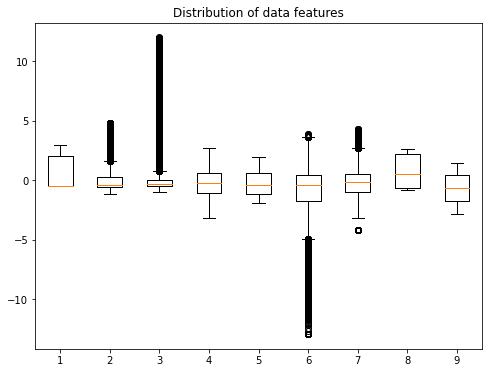

In [22]:
## Scale data:
data_new_features = scaler.transform(data_new_features);

fig = plt.figure(figsize=(8,6))
plt.boxplot(data_new_features, showfliers=True);
plt.title('Distribution of data features');



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   name     1204025 non-null  object
 1   album    1204025 non-null  object
 2   artists  1204025 non-null  object
 3   labels   1204025 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 32.2+ MB


None

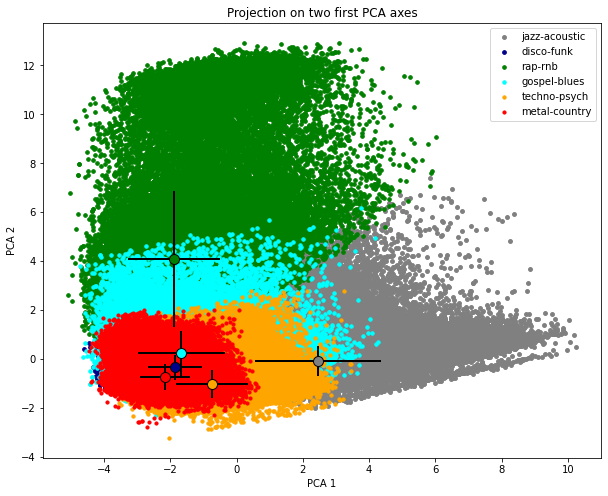

In [23]:
## Apply Kmean clustering (label each new song):

labels_kmeans2 = kmeans.predict(data_new_features);

## combine results with track descriptions
data_new_titles['labels'] = labels_kmeans2
display(data_new_titles.info())


#Analyse avec PCA:
pca = PCA(n_components=2);
data_2D = pca.fit_transform(X=data_new_features);

fig = plt.figure(figsize=(10,8))
#plt.scatter(data_2D[:,0],data_2D[:,1],c=labels_clf, cmap=plt.cm.Spectral)
for label in np.unique(labels_kmeans2):
    lab=labels[label]
    plt.scatter(data_2D[labels_kmeans2==label, 0], data_2D[labels_kmeans2==label, 1], facecolors=c[label], s=15-label, label=lab)
# add mean of each group and std
for label in np.unique(labels_kmeans2):
    avg1=data_2D[labels_kmeans2==label, 0].mean()
    avg2=data_2D[labels_kmeans2==label, 1].mean()
    std1=data_2D[labels_kmeans2==label, 0].std()
    std2=data_2D[labels_kmeans2==label, 1].std()
    plt.vlines(x=avg1, ymin=avg2-std2, ymax=avg2+std2, colors='black', linestyles='-', lw=2, zorder=9)
    plt.hlines(y=avg2, xmin=avg1-std1, xmax=avg1+std1, colors='black', linestyles='-', lw=2, zorder=9)
    plt.scatter(avg1, avg2, s=100, edgecolors="black", facecolors=c[label], zorder=10)

plt.xlabel('PCA 1');
plt.ylabel('PCA 2');
plt.title("Projection on two first PCA axes");
plt.legend()


In [24]:
## Display some tracks for a group:

# to check a specific label:
display(data_new_titles[labels_kmeans2==0].head(20))

# to check an artist / album....
display(data_new_titles[data_new_titles["artists"]=="['Bruce Cockburn']"].head(50))
display(data_new_titles[data_new_titles["artists"]=="['Will Young']"].head(50))
display(data_new_titles[data_new_titles["labels"]==5].head(50))

,name,album,artists,labels
40,Love Is A Matter Of Distance,Fridays Child,['Will Young'],0
44,Going My Way,Fridays Child,['Will Young'],0
48,All The Ways I Want You,Dart To The Heart,['Bruce Cockburn'],0
49,Bone In My Ear,Dart To The Heart,['Bruce Cockburn'],0
50,Burden Of The Angel/Beast,Dart To The Heart,['Bruce Cockburn'],0
52,Southland Of The Heart,Dart To The Heart,['Bruce Cockburn'],0
53,Train In The Rain,Dart To The Heart,['Bruce Cockburn'],0
54,Someone I Used To Love,Dart To The Heart,['Bruce Cockburn'],0
55,Love Loves You Too,Dart To The Heart,['Bruce Cockburn'],0
56,Sunrise On The Mississippi,Dart To The Heart,['Bruce Cockburn'],0


,name,album,artists,labels
47,Listen For The Laugh,Dart To The Heart,['Bruce Cockburn'],1
48,All The Ways I Want You,Dart To The Heart,['Bruce Cockburn'],0
49,Bone In My Ear,Dart To The Heart,['Bruce Cockburn'],0
50,Burden Of The Angel/Beast,Dart To The Heart,['Bruce Cockburn'],0
51,Scanning These Crowds,Dart To The Heart,['Bruce Cockburn'],1
...,...,...,...,...
325273,Blueberry Hill,Breakfast In New Orleans Dinner In Timbuktu,['Bruce Cockburn'],0
325274,Let The Bad Air Out,Breakfast In New Orleans Dinner In Timbuktu,['Bruce Cockburn'],5
325275,Look How Far,Breakfast In New Orleans Dinner In Timbuktu,['Bruce Cockburn'],0
325276,Deep Lake,Breakfast In New Orleans Dinner In Timbuktu,['Bruce Cockburn'],0


,name,album,artists,labels
36,Love The One You're With,Fridays Child,['Will Young'],1
37,Your Game,Fridays Child,['Will Young'],1
38,Stronger,Fridays Child,['Will Young'],1
39,Leave Right Now,Fridays Child,['Will Young'],1
40,Love Is A Matter Of Distance,Fridays Child,['Will Young'],0
41,Dance The Night Away,Fridays Child,['Will Young'],1
42,Very Kind,Fridays Child,['Will Young'],1
43,Free,Fridays Child,['Will Young'],1
44,Going My Way,Fridays Child,['Will Young'],0
45,Out Of My Mind,Fridays Child,['Will Young'],1


,name,album,artists,labels
0,Testify,The Battle Of Los Angeles,['Rage Against The Machine'],5
1,Guerrilla Radio,The Battle Of Los Angeles,['Rage Against The Machine'],5
4,Sleep Now In the Fire,The Battle Of Los Angeles,['Rage Against The Machine'],5
5,Born of a Broken Man,The Battle Of Los Angeles,['Rage Against The Machine'],5
6,Born As Ghosts,The Battle Of Los Angeles,['Rage Against The Machine'],5
...,...,...,...,...
202,Cosmic Christ,The Jesus Experience,['Bride'],5
203,The World I Know,The Jesus Experience,['Bride'],5
217,Blow It All Away,This Is It,['Bride'],5
218,To the Sky,This Is It,['Bride'],5
